In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import butter, hilbert, filtfilt, freqz, coherence
from scipy import stats
import random
import sys
sys.path.append('/Volumes/kaylab/Code.Repository/Python/') # where OpenEphys is stored

import OpenEphys


sf = 30000

ddir = '/Volumes/kaylab/DataStores/Data/BO/SiProbe/' # data directory

# choose data folder where files are stored
#dfold = 'RK90_2016-09-11_raw_30k_30pres_EMB'
dfold = 'RK90_2016-09-29_raw_30k_30pres_EMB_awake'
#clust1 = [2,3,4,5,6,7,8] # clusters 7&8 are both CH2 spikes
#clust2 = [2,3,4,5,6,7]
#clust_names = ['sh1 - multi','sh1 - multi','sh1 - multi','sh1 - CH0','sh1 - CH8',
#              'sh1 - CH2','sh1 - CH2','sh2 - multi','sh2 - multi','sh2 - CH8',
#              'sh2 - multi','sh2 - multi','sh2 - multi']


# number of odor presentations
nop = 30
# save figures?
sflag = 0;

In [2]:
# load LFP data
filepath = ddir + dfold + '/' + dfold + '_LFP.dat'
ssLFP = np.fromfile(filepath, dtype='float') #subsampled LFP
sssf = 3000 # subsampled frequency
# NOTE!!! Downsampling not only saves space, but is also necessary to construct filters that 
# operate in the beta range

In [3]:
# Load events, extract odor periods
eventsname = 'all_channels.events'
filepath = ddir + dfold + '/' + eventsname
Events = OpenEphys.loadEvents(filepath)
odor_periods = Events['timestamps']-Events['timestamps'][0]
odor_periods = odor_periods[2:]
# For some odd reason the TTL pulses will sometimes duplicate a few miliseconds after eachother
# Smooth over the duplicates by binning time in 0.3s bins
dl = 10*np.squeeze(ssLFP.shape) # data length
a,b = np.histogram(odor_periods,np.arange(0,dl,0.3*sf))
b = b[1:] # The first edge is 0 so we skip it
odor_periods = b[a>0] # index where bin count is > 1
# For some reason the last TTL OFF is not saved, so I add one 3s after the last ON
odor_periods = np.hstack((odor_periods,odor_periods[-1]+3*sf))

loading events...


In [4]:
def load_spikes_from_kwik(dfile, clust_choice, use_clust_choice):
    '''
    Inputs : dfile        - file directory (including filename)
             clust_choice - list of cluster labels you want to extract
             use_clust_choice - if 1 t
        
    Outputs: SPK          - list of spike times (in samples) for each cluster
    '''
    import h5py
    with h5py.File(dfile,'r') as D:
        # for viewing contents of folders
        # dv=D['/channel_groups/0/spikes/time_samples']
        # for i in iter(dv):
            # print(i)
        time_samples = D.get('/channel_groups/0/spikes/time_samples')
        np_time_samples = np.array(time_samples)
        cluster_labels = D.get('/channel_groups/0/spikes/clusters/main')
        np_cluster_labels = np.array(cluster_labels) # label of each individual spike
        cluster_names = D.get('/channel_groups/0/clusters/main')
        np_cluster_names = np.array(cluster_names) # name of each cluster category
        # must additionally convert from <U2 to int32
        np_cluster_names = np_cluster_names.astype('int32')
        
    SPK = []
    if use_clust_choice == 1:
        for i in range(len(clust_choice)):
            temp_ind = np.squeeze(np.array(np.where(np_cluster_labels == clust_choice[i])))
            SPK.append(np_time_samples[temp_ind])
    else:
        for i in range(len(np_cluster_names)):
            temp_ind = np.squeeze(np.array(np.where(np_cluster_labels == np_cluster_names[i])))
            SPK.append(np_time_samples[temp_ind])
    return SPK, np_cluster_names


# load spike times of each cluster for both shanks
dfile1 = ddir + dfold + '/2017/shank1CMR/' + dfold + '_shank1CMR' + '.kwik'
[SPK1,clust_names1] = load_spikes_from_kwik(dfile1, [], 0)
    
dfile2 = ddir + dfold + '/2017/shank2CMR/' + dfold + '_shank2CMR' + '.kwik'
[SPK2,clust_names2] = load_spikes_from_kwik(dfile2, [], 0)

# remove clusters with <=10 spikes
n=np.array([SPK1[i].size for i in range(len(SPK1))])
m=np.where(n<=10)
m=sorted(m[0],reverse=True)
for i in m:
    del SPK1[i];
n=np.array([SPK2[i].size for i in range(len(SPK2))])
m=np.where(n<=10)
m=sorted(m[0],reverse=True)
for i in m:
    del SPK2[i];

SPK = SPK1+SPK2
nc1 = len(SPK1)
nc2 = len(SPK2)
# Spike times from both are saved in a single list SPK!

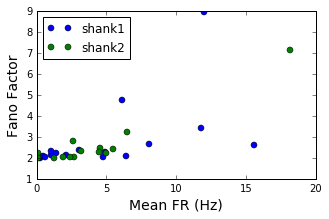

In [16]:
# Fano Factors

def get_FR(spikes,bw,sf,maxt):
    # spikes     -     vector of spike times
    # bw         -     bin window (s)
    # sf         -     sampling fq
    # maxt       -     max time bin
    bins = np.arange(0,maxt,bw)
    [fr,bleh] = np.histogram(spikes/sf,bins)
    fr = fr/bw # convert counts to rate
    return fr

sflag = 1
bw = 0.5 # bin width (s) for measuring FR

# shank1
FR1 = [];
ff1 = [];
mfr1 = [];
for i in range(nc1):
    FR1.append(get_FR(SPK1[i],bw,sf,dl/sf))
    mfr1.append(np.mean(FR1[i]))
    ff1.append(np.var(FR1[i])/mfr1[i]) # Fano factor

        
# shank2
FR2 = [];
ff2 = [];
mfr2 = [];
for i in range(nc2):
    FR2.append(get_FR(SPK2[i],bw,sf,dl/sf))
    mfr2.append(np.mean(FR2[i]))
    ff2.append(np.var(FR2[i])/mfr2[i])  # Fano factor


plt.figure(figsize=(5,3))
plt.plot(mfr1,ff1,"o")
plt.plot(mfr2,ff2,"o")
plt.ylabel('Fano Factor',fontsize = 14)
plt.xlabel('Mean FR (Hz)',fontsize = 14)
plt.legend(["shank1","shank2"],loc = 'best')

if sflag == 1:
    plt.savefig('figs/'+dfold+'_MFRvsFF.png', bbox_inches='tight')

In [ ]:
# Plot ISI distributions
sflag = 1
nbins = 50 # nbins for plotting ISI histogram

# shank1
nsb = np.ceil(np.sqrt(nc1)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    ISI_temp = 1000*(SPK1[i][1:]-SPK1[i][0:-1])/sf
    plt.subplot(nsb,nsb,i+1)
    ISI_temp = ISI_temp[ISI_temp != 0] # remove 0s (there shouldn't be any)
    CV_temp = stats.variation(ISI_temp) # coeff of variation
    plt.hist(ISI_temp, bins=np.logspace(-1,5,nbins), edgecolor = 'none',color='k')
    plt.gca().set_xscale('log')
    #plt.hist(ISI_temp, bins=np.linspace(0,10000,nbins), edgecolor = 'none')
    plt.title('Cl'+str(clust_names1[i])+', '+'CV: '+str("%.2f" % CV_temp)+'\n'+str(len(SPK1[i]))+' spikes')
    plt.tight_layout(pad=1.05, h_pad=None, w_pad=None, rect=None) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
        plt.xlabel('ms')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_ISI1.png', bbox_inches='tight')
        
# shank2
nsb = np.ceil(np.sqrt(nc2)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    ISI_temp = 1000*(SPK2[i][1:]-SPK2[i][0:-1])/sf
    plt.subplot(nsb,nsb,i+1)
    ISI_temp = ISI_temp[ISI_temp != 0] # remove 0s (there shouldn't be any)
    CV_temp = stats.variation(ISI_temp) # coeff of variation
    plt.hist(ISI_temp, bins=np.logspace(-1,5,nbins), edgecolor = 'none',color='k')
    plt.gca().set_xscale('log')
    plt.title('Cl'+str(clust_names2[i])+', '+'CV: '+str("%.2f" % CV_temp)+'\n'+str(len(SPK2[i]))+' spikes')
    plt.tight_layout(pad=1.05, h_pad=None, w_pad=None, rect=None) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
        plt.xlabel('ms')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_ISI2.png', bbox_inches='tight')    
# log(x) = 10 for x~20000 (20s)

In [5]:
# Extract LFP and spikes in odor periods
start = odor_periods[0::2] - sf # add 1s to each end of odor period
stop = odor_periods[1::2] + sf

ssLFP_op = list()
SPK_op = list()
op_num_spk = np.zeros(len(SPK)) # This will store number of real spikes during odor
op_num_spk_randm = np.zeros(len(SPK)) # this will store mean number of rand gen spikes during odor
op_num_spk_randstd = np.zeros(len(SPK)) # this will store mean number of rand gen spikes during odor

for i in range(nop):
    # remember, LFP is subsampled by 10
    ssLFP_op.append(ssLFP[start[i]/10:stop[i]/10])
    SPKtmp = list()
    op_num_spk_temp = np.zeros(len(SPK))
    op_num_spk_randm_temp = np.zeros(len(SPK))
    op_num_spk_randstd_temp = np.zeros(len(SPK))
    for s in range(len(SPK)):
        # find spk times in odor periods. Don't save spikes within 10 smaples of the stop
        # to avoid later indexing issues when indexing last element of subsampled array
        sind = np.array(np.where((SPK[s] > start[i]) & (SPK[s] < (stop[i]-10))))
        sind = sind.astype(int) # convert type to int
        SPKtmp.append(SPK[s][sind]-start[i]) # subtract away start time of odor period
        op_num_spk_temp[s] = sind.size
        # fake spikes
        nst = len(SPK[s]) # number spikes tot (in given spiketrain)
        nsim=50 # number of random simulations
        store_sims = np.zeros(nsim)
        for srand in range(nsim):
            rand_spikes = np.floor(dl*np.random.random(nst)).astype(int) # gen rand spikes
            sind_rand = np.array(np.where((rand_spikes > start[i]) & (rand_spikes < (stop[i]-10))))
            sind_rand = sind_rand.astype(int) # convert type to int
            store_sims[srand] = sind_rand.size
        op_num_spk_randm_temp[s] = np.mean(store_sims) # simulation mean
        op_num_spk_randstd_temp[s] = np.std(store_sims) # simulation std
    SPK_op.append(SPKtmp)
    op_num_spk = op_num_spk+op_num_spk_temp # total # of spikes in odor periods
    op_num_spk_randm = op_num_spk_randm+op_num_spk_randm_temp
    op_num_spk_randstd = op_num_spk_randstd+op_num_spk_randstd_temp
    

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


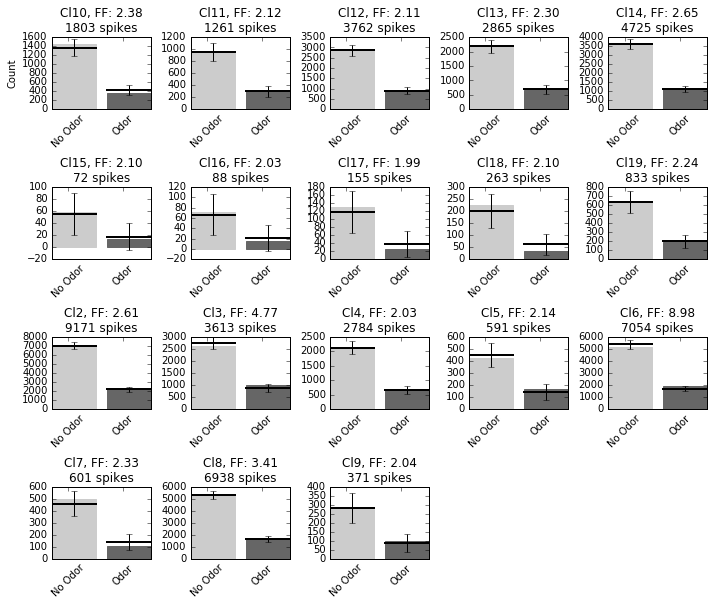

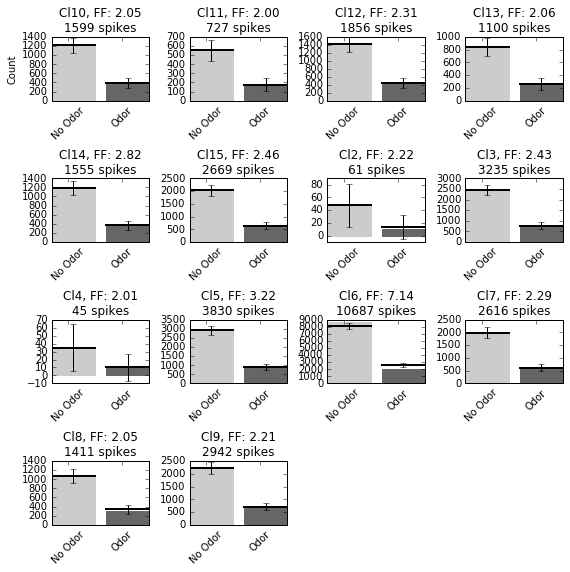

In [18]:
# do cells fire more or less durring odor periods?
sflag = 1

op_tot_time = np.diff(odor_periods)/sf
op_tot_time = np.sum(op_tot_time[::2]) # total time durring odor periods (s)
no_tot_time = ssLFP.size/sssf - op_tot_time # total time durring no odor periods (s)

no_num_spk = np.zeros(len(SPK))
no_num_spk_randm = np.zeros(len(SPK))
no_num_spk_randstd = np.zeros(len(SPK))
for i in range(len(SPK)):
    no_num_spk[i] = len(SPK[i])-op_num_spk[i] # # of spikes in no odor periods
    no_num_spk_randm[i] = len(SPK[i])-op_num_spk_randm[i] # mean # of spikes in no odor periods
    ono_meanratio = no_num_spk_randm[i]/op_num_spk_randm[i]
    no_num_spk_randstd[i] = ono_meanratio*op_num_spk_randstd[i]/2 # scale std by ratio of odor to no odor mean #


# plot results
# shank1
nsb = np.ceil(np.sqrt(nc1)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    ax = plt.subplot(nsb,nsb,i+1)
    #blist = plt.bar([1,2],[no_num_spk[i]/no_tot_time, op_num_spk[i]/op_tot_time]) # FR
    blist = plt.bar([1,2],[no_num_spk[i], op_num_spk[i]]) # Count
    blist[0].set_color([0.8,0.8,0.8])
    #blist[0].set_edgecolor('k')
    blist[1].set_color([0.4,0.4,0.4])
    plt.plot([1,1.8],[no_num_spk_randm[i],no_num_spk_randm[i]],'k',linewidth=2)
    ax.errorbar(1.4, no_num_spk_randm[i], yerr=no_num_spk_randstd[i],ecolor='k')
    plt.plot([2,2.8],[op_num_spk_randm[i],op_num_spk_randm[i]],'k',linewidth=2)
    ax.errorbar(2.4, op_num_spk_randm[i], yerr=op_num_spk_randstd[i],ecolor='k')
    plt.title('Cl'+str(clust_names1[i])+', '+'FF: '+str("%.2f" % ff1[i])+'\n'+str(len(SPK1[i]))+' spikes')
    plt.tick_params(axis='x',bottom='off') # remove x-axis ticks
    plt.xticks([1.3,2.3], ['No Odor', 'Odor'])
    ax.set_xticklabels(('No Odor', 'Odor'),rotation=45)
    plt.tight_layout(pad=1.05) # fit titles in subplots
    if i == 0:
        #plt.ylabel('Avg FR (Hz)')
        plt.ylabel('Count')
if sflag == 1:
    #plt.savefig('figs/'+dfold+'_AVG-FR-durring-OP-SPK1.png', bbox_inches='tight')
    plt.savefig('figs/'+dfold+'_Count-durring-OP-SPK1.png', bbox_inches='tight')
        
# shank2
nsb = np.ceil(np.sqrt(nc2)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    ax = plt.subplot(nsb,nsb,i+1)
    #blist = plt.bar([1,2],[no_num_spk[i+nc1]/no_tot_time, op_num_spk[i+nc1]/op_tot_time])
    blist = plt.bar([1,2],[no_num_spk[i+nc1], op_num_spk[i+nc1]])
    blist[0].set_color([0.8,0.8,0.8])
    #blist[0].set_edgecolor('k')
    blist[1].set_color([0.4,0.4,0.4])
    plt.plot([1,1.8],[no_num_spk_randm[i+nc1],no_num_spk_randm[i+nc1]],'k',linewidth=2)
    ax.errorbar(1.4, no_num_spk_randm[i+nc1], yerr=no_num_spk_randstd[i+nc1],ecolor='k')
    plt.plot([2,2.8],[op_num_spk_randm[i+nc1],op_num_spk_randm[i+nc1]],'k',linewidth=2)
    ax.errorbar(2.4, op_num_spk_randm[i+nc1], yerr=op_num_spk_randstd[i+nc1],ecolor='k')
    plt.title('Cl'+str(clust_names2[i])+', '+'FF: '+str("%.2f" % ff2[i])+'\n'+str(len(SPK2[i]))+' spikes')
    plt.tick_params(axis='x',bottom='off') # remove x-axis ticks
    plt.xticks([1.3,2.3], ['No Odor', 'Odor'])
    ax.set_xticklabels(('No Odor', 'Odor'),rotation=45)
    plt.tight_layout(pad=1.05) # fit titles in subplots
    if i == 0:
        #plt.ylabel('Avg FR (Hz)')
        plt.ylabel('Count')
if sflag == 1:
    #plt.savefig('figs/'+dfold+'_AVG-FR-durring-OP-SPK2.png', bbox_inches='tight')
    plt.savefig('figs/'+dfold+'_Count-durring-OP-SPK2.png', bbox_inches='tight')


In [6]:
def butter_env(order, low, high, signal):
    b, a = butter(order, [low, high], btype='bandpass')
    filt_signal = filtfilt(b, a, signal)
    # Amplitude of analytic signal is the envelope
    hilb_filt_signal = hilbert(filt_signal)
    filt_signal_env = np.abs(hilb_filt_signal)
    # The instantaneous phase corresponds to the phase angle of the analytic signal
    filt_signal_ph = np.angle(hilb_filt_signal)
    return filt_signal, filt_signal_env, filt_signal_ph

In [7]:
def spike_field_prod_with_rand(spikes,field):
    # This function indexes field by spikes AND by a random array the same length as spikes
    # NOTE: this function assumes that spikes are sampled 10x higher than field
    # spike sample times must be subsampled and rounded to index ssLFP envelope
    ssinds = np.rint(0.1*np.array(spikes)) # round to nearest integer
    ssinds = ssinds.astype(int) # convert type to int
    SFprod = field[ssinds]
    # Do the same for randomly generated spikes as a control
    randinds = field.size*np.random.sample(spikes.size)
    randinds = randinds.astype(int) # convert type to int
    RFprod = field[randinds]
    return SFprod, RFprod

In [8]:
def spike_field_coh(spike_times,field,sssf):
# This function uses the scipy.signal.coherence function. Must be imported
# Assuming spike times are given in units of samples.
# Also assuming LFP is subsampled by 10
# This function bins spike times in bins of LFP sampling time, then computes coherence
    from scipy.signal import coherence
    bw = 10
    bins = np.arange(0,10*len(field),bw)
    [binned_spikes,bleh] = np.histogram(spike_times,bins)
    if len(binned_spikes) < len(field): # ensure binned spikes and LFP are same len
        binned_spikes=np.append(binned_spikes,0) # add zero to end
    elif len(binned_spikes) > len(field):
        binned_spikes=np.delete(binned_spikes,0) # delete 1st element
    f, Cxy = coherence(binned_spikes, field, sssf, nperseg=2000)
    # higher nperseg --> finer fq resolution
    return f, Cxy

In [ ]:
SPHprodth = list() # SPHprodth will have length = len(SPK)
RPHprodth = list()
for i in range(len(SPK)):
    SFprod, RFprod = spike_field_prod_with_rand(SPK[i],LFPth_ph)
    SPHprodth.append(SFprod)
    RPHprodth.append(RFprod)

In [9]:
# Filter entire session for each frequency band

# Theta filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 1 / nyq
high = 13 / nyq
order = 3
LFPth, LFPth_env, LFPth_ph = butter_env(order, low, high, ssLFP)


# Beta filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 10 / nyq # it turns out that lowcut must be <15Hz to capture the large beta amplitude
high = 33 / nyq
order = 4
LFPb, LFPb_env, LFPb_ph = butter_env(order, low, high, ssLFP)


# low gamma filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 35 / nyq
high = 65 / nyq
order = 5
LFPlg, LFPlg_env, LFPlg_ph = butter_env(order, low, high, ssLFP)



# high gamma filtered LFP envelope with Butterworth filter
#========================================================#
nyq = 0.5 * sssf
low = 60 / nyq
high = 100 / nyq
order = 5
LFPhg, LFPhg_env, LFPhg_ph = butter_env(order, low, high, ssLFP)

In [ ]:
# Spike-Theta phase histograms

LFPth_ph_1st70s = LFPth_ph[0:60*sssf]
#LFPth_ph_1st70s = LFPth_ph[180*sssf:]

SPHprodth = list() # SPHprodth will have length = len(SPK)
RPHprodth = list()
SPK_1st70s = list()
SFCth = []
SFCth_max = []
SFCth_rand = []
SFCth_rand_max = []
ENTth = []
ENTth_rand = []
for i in range(len(SPK)):
    ind_temp = np.array(np.where(SPK[i] < 60*sf))
    #SPK_1st70s.append(SPK[i][ind_temp]-180*sf)
    SPK_1st70s.append(SPK[i][ind_temp])
    SFprod, RFprod = spike_field_prod_with_rand(SPK_1st70s[i],LFPth_ph_1st70s)
    SPHprodth.append(SFprod)
    RPHprodth.append(RFprod)
    f, Cxy = spike_field_coh(SPK_1st70s[i],LFPth_ph_1st70s,sssf)
    SFCth.append(Cxy)
    randSPK = 10*len(LFPth_ph_1st70s)*np.random.random(SPK_1st70s[i].size)
    f, Cxy = spike_field_coh(randSPK,LFPth_ph_1st70s,sssf)
    SFCth_rand.append(Cxy)
    if len(SPK_1st70s[i][0]) > 30: #SFC is meaningless with too few spikes. 30 seems like good cutoff
        SFCth_max.append(np.max(SFCth[i][0:20]))
        SFCth_rand_max.append(np.max(SFCth_rand[i][0:20]))
        ENTth.append()
    else:
        SFCth_max.append(np.nan)
        SFCth_rand_max.append(np.nan)
    
sflag = 1

# Plot spike-LFP theta phase histograms
nbins = 15
# shank1
nsb = np.ceil(np.sqrt(nc1)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[i].T, nbins, edgecolor = 'none',color = [0,0.5,0])
    plt.hist(RPHprodth[i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names1[i])+', '+'SFC: '+str("%.2f" % np.max(SFCth[i][0:20]))+'\n'+str(SPHprodth[i].size)+' spikes')
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH1_1stmin.png', bbox_inches='tight')
    #plt.savefig('figs/'+dfold+'_SPHhistTH1_last3min.png', bbox_inches='tight')
        
# shank2
nsb = np.ceil(np.sqrt(nc2)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodth[nc1+i].T, nbins, edgecolor = 'none',color = [0,0.5,0])
    plt.hist(RPHprodth[nc1+i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names2[i])+', '+'SFC: '+str("%.2f" % np.max(SFCth[nc1+i][0:20]))+'\n'+str(SPHprodth[nc1+i].size)+' spikes')
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistTH2_1stmin.png', bbox_inches='tight')
    #plt.savefig('figs/'+dfold+'_SPHhistTH2_last3min.png', bbox_inches='tight')
        

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/scipy/signal/spectral.py:622: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


ERROR! Session/line number was not unique in database. History logging moved to new session 228


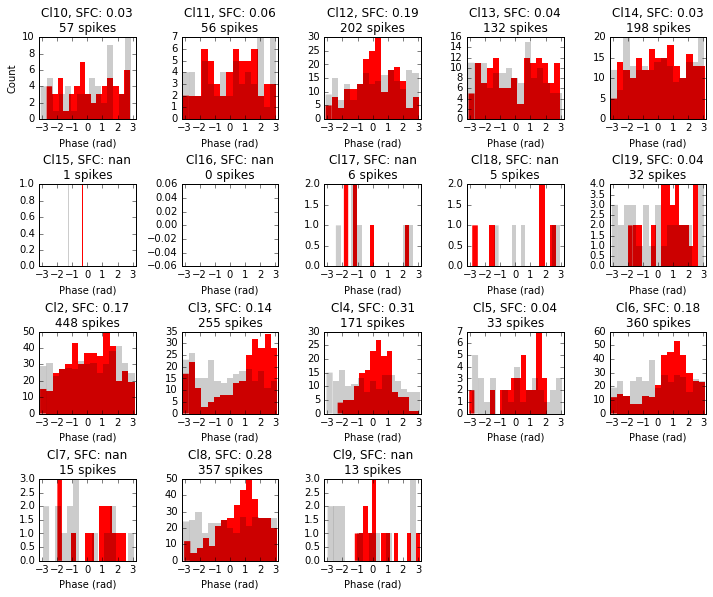

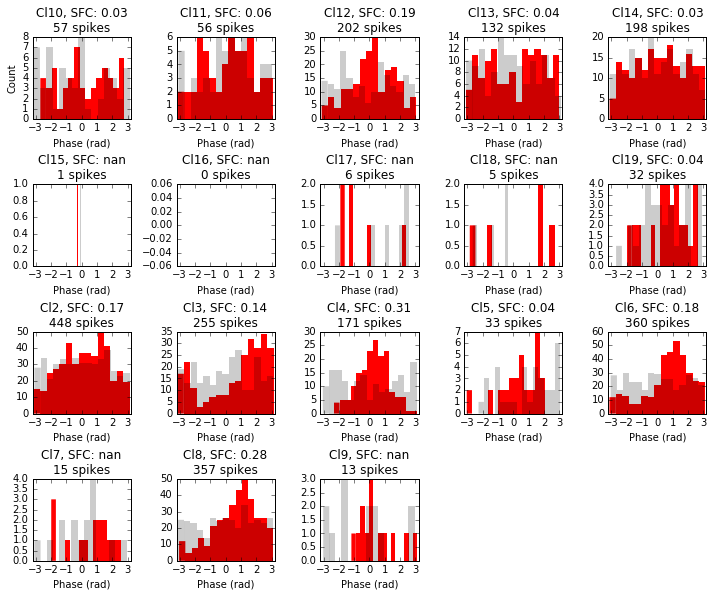

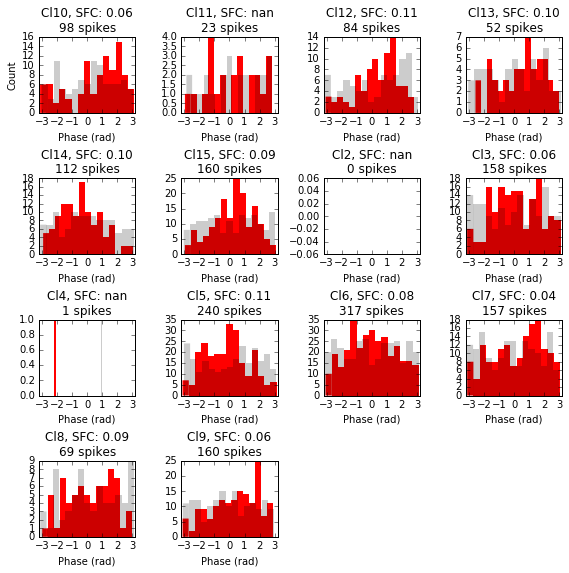

In [288]:
# Spike-phase histograms and spike-field coherence for beta during odor periods
# Filter odor periods only for beta
nyq = 0.5 * sssf
low = 10 / nyq # it turns out that lowcut must be <15Hz to capture the large beta amplitude
high = 33 / nyq
order = 4

LFPb_op = list()
LFPb_env_op = list()
LFPb_ph_op = list()
for i in range(nop):
    LFPbtemp, LFPb_envtemp, LFPb_phtemp = butter_env(order, low, high, ssLFP_op[i])
    LFPb_op.append(LFPbtemp)
    LFPb_envtemp[0:50] = 0 # Get rid of edge effects by setting envelope on either edge = 0!!!
    LFPb_envtemp[-50:] = 0 # This will also allow detection of suprathresh at start of window!
    LFPb_env_op.append(LFPb_envtemp)
    LFPb_ph_op.append(LFPb_phtemp)


# spike-LFP phase histograms

# These must only be calculated for regions where beta power is greater than some threshold
thb = 0.25*max(np.hstack(LFPb_env_op)) # threshold
startb_op = list()
stopb_op = list()
for i in range(nop):
    yo = LFPb_env_op[i] >= thb
    yo = yo.astype(float) # convert boolean to float
    yo = np.diff(yo)
    startb_op.append(10*np.squeeze(np.array(np.where(yo == 1)))) # multiply by 10 becaise LFP is subsampled
    stopb_op.append(10*np.squeeze(np.array(np.where(yo == -1)))) # multiply by 10 becaise LFP is subsampled
    if stopb_op[i].size == startb_op[i].size+1:
        stopb_op[i] = np.delete(stopb_op[i],0) # start and stop must be same length and aligned!

# calculate Spike-LFP phase product and SFC for thresholded regions
SPHprod = list() # SPHprod will have length = len(SPK)
RPHprod = list() # same as SPHprod but for random spikes
LFPb_cat = np.empty(0) # initialize array which will concatenate all beta periods
SPKb_cat = [None]*len(SPK)
for s in range(len(SPK)):
    cumulative_time_shift = 0 # cumulative shift in time to concatenate spike times because each op starts from 0
    SPHprod_temp = list()
    RPHprod_temp = list()
    SPKb_cat[s] = np.empty(0)
    for i in range(nop):
        # extract spikes for each start/stop pair of the thresholded region
        for b in range(startb_op[i].size):
            if np.isscalar(startb_op[i]): # if scalar don't index by b (only one beta in this op)
                current_start = startb_op[i] # only saving this to realign spikes for 1D cat
                bool_array =(SPK_op[i][s] > startb_op[i]) & (SPK_op[i][s] < stopb_op[i])
                if s == 0: # concatenate LFPb only for first s (since s is over spikes)
                    LFPb_cat = np.append(LFPb_cat,LFPb_op[i][startb_op[i]/10:stopb_op[i]/10])
            else:
                current_start = startb_op[i][b] # only saving this to realign spikes for 1D cat
                bool_array =(SPK_op[i][s] > startb_op[i][b]) & (SPK_op[i][s] < stopb_op[i][b])
                if s == 0: # concatenate LFPb only for first s (since s is over spikes)
                    LFPb_cat = np.append(LFPb_cat,LFPb_op[i][startb_op[i][b]/10:stopb_op[i][b]/10])
            sind = np.array(np.where(np.squeeze(bool_array)))
            if sind.size > 0: # trouble dealing with empty arrays
                #ssinds = np.rint(0.1*np.array(SPK_op[i][s][0][sind])) # round to nearest integer
                #ssinds = ssinds.astype(int) # convert type to int
                # concatenate spike-phase products
                [SFprod,RFprod] = spike_field_prod_with_rand(SPK_op[i][s][0][sind],LFPb_ph_op[i])
                SPHprod_temp.append(SFprod)
                RPHprod_temp.append(RFprod)
                # concatenate spike times into single vector (used for SFC)
                SPKb_cat[s] = np.append(SPKb_cat[s],SPK_op[i][s][0][sind]+cumulative_time_shift-current_start)
            if np.isscalar(startb_op[i]): # update time_shift
                cumulative_time_shift = cumulative_time_shift+stopb_op[i]-startb_op[i]
            else:
                cumulative_time_shift = cumulative_time_shift+stopb_op[i][b]-startb_op[i][b]
                # NOTE: must subtract 2 different start times! Current start, and past start!
    # save spike-phase products for each cluster
    if len(SPHprod_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprod.append(np.empty( shape=(0, 0) )) # must add empty ARRAY (not LIST) for later processing
        RPHprod.append(np.empty( shape=(0, 0) )) # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprod.append(np.hstack(SPHprod_temp))
        RPHprod.append(np.hstack(RPHprod_temp))
    

# Compute SFC
SFCb = []
SFCb_max = []
SFCb_rand = []
SFCb_rand_max = []
for i in range(len(SPK)):
    f, Cxy = spike_field_coh(SPKb_cat[i],LFPb_cat,sssf)
    SFCb.append(Cxy)
    randSPK = 10*len(LFPb_cat)*np.random.random(SPKb_cat[i].size)
    f, Cxy = spike_field_coh(randSPK,LFPb_cat,sssf)
    SFCb_rand.append(Cxy)
    if len(SPKb_cat[i]) > 30: #SFC is meaningless with too few spikes. 30 seems like good cutoff
        SFCb_max.append(np.max(SFCb[i][0:30]))
        SFCb_rand_max.append(np.max(SFCb_rand[i][0:30]))
    else:
        SFCb_max.append(np.nan)
        SFCb_rand_max.append(np.nan)
    
# Plot spike-LFP phase histograms
sflag = 0
nbins = 15
# shank1
nsb = np.ceil(np.sqrt(nc1)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprod[i].T, nbins, edgecolor = 'none',color='r')
    plt.hist(RPHprod[i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names1[i])+', '+'SFC: '+str("%.2f" % SFCb_max[i])+'\n'+str(SPHprod[i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistB1.png', bbox_inches='tight')
        
# shank2
nsb = np.ceil(np.sqrt(nc2)) # number of subplot rows/cols (always square)
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprod[i+nc1].T, nbins, edgecolor = 'none',color='r')
    plt.hist(RPHprod[i+nc1].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title(str(clust_names2[i])+'\n'+str(SPHprod[i+nc1].size)+' spikes')
    plt.title('Cl'+str(clust_names2[i])+', '+'SFC: '+str("%.2f" % SFCb_max[i+nc1])+'\n'+str(SPHprod[i+nc1].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistB2.png', bbox_inches='tight')


In [ ]:
# obtain start and stop of low and high gamma periods above a threshold
thlg = 0.25*max(LFPlg_env) # low gamma threshold
thhg = 0.2*max(LFPhg_env) # high gamma threshold
yolg = LFPlg_env >= thlg
yohg = LFPhg_env >= thhg
yolg = yolg.astype(float) # convert boolean to float
yohg = yohg.astype(float) # convert boolean to float
yolg = np.diff(yolg)
yohg = np.diff(yohg)
startlg = np.squeeze(np.array(np.where(yolg == 1)))
stoplg = np.squeeze(np.array(np.where(yolg == -1)))
stoplg = stoplg[stoplg != 0] # if LFP happends start with high power then first stop will be 0
if len(stoplg) == len(startlg)+1:
    stoplg = np.delete(stoplg,0) # start and stop must be same length and aligned!
starthg = np.squeeze(np.array(np.where(yohg == 1)))
stophg = np.squeeze(np.array(np.where(yohg == -1)))
stophg = stophg[stophg != 0] # if LFP happends start with high power, then first stop will be 0
if len(stophg) == len(starthg)+1:
    stophg = np.delete(stophg,0) # start and stop must be same length and aligned!

# Get spike-LFP phase products low/high gamma periods
SPHprodlg = list() # SPHprodlg will have length = len(SPK)
SPHprodhg = list()
RPHprodlg = list() # SPHprodlg will have length = len(SPK)
RPHprodhg = list()
lg_tot_spk = np.zeros(len(SPK)) # also save tot number of spikes in lg/hg
hg_tot_spk = np.zeros(len(SPK))
LFPlg_cat = [] # initialize list which I will later convert to 1D array (np.append is suuuuper slow)
SPKlg_cat = [None]*len(SPK)
LFPhg_cat = [] # initialize list which I will later convert to 1D array (np.append is suuuuper slow)
SPKhg_cat = [None]*len(SPK)
for i in range(len(SPK)):
    # low gamma
    SPHprodlg_temp = list()
    RPHprodlg_temp = list()
    SPKlg_cat[i] = np.empty(0) # np.append is slow, but since there are few spikes per j it ok
    cumulative_time_shiftlg = 0 # cumulative shift in time to concatenate spike times
    for j in range(startlg.size):
        ind_temp = np.array(np.where((SPK[i] > 10*startlg[j]) & (SPK[i] < 10*stoplg[j]-10)))
        spk_temp = SPK[i][ind_temp] - 10*startlg[j]
        if i == 0:
            LFPlg_cat.append(LFPlg[startlg[j]:stoplg[j]]) # only cat LFP once
        [SFprod,RFprod] = spike_field_prod_with_rand(spk_temp,LFPlg_ph[startlg[j]:stoplg[j]])
        SPHprodlg_temp.append(SFprod)
        RPHprodlg_temp.append(RFprod)
        lg_tot_spk[i] = lg_tot_spk[i] + ind_temp.size
        SPKlg_cat[i] = np.append(SPKlg_cat[i],spk_temp+cumulative_time_shiftlg)
        cumulative_time_shiftlg = cumulative_time_shiftlg + stoplg[j]-startlg[j]
    # save spike-phase products for each cluster
    if len(SPHprodlg_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprodlg.append(np.empty( shape=(0, 0) ))
        RPHprodlg.append(np.empty( shape=(0, 0) ))
        # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprodlg.append(np.hstack(SPHprodlg_temp))
        RPHprodlg.append(np.hstack(RPHprodlg_temp))
    # high gamma
    SPHprodhg_temp = list()
    RPHprodhg_temp = list()
    SPKhg_cat[i] = np.empty(0)
    cumulative_time_shifthg = 0 # cumulative shift in time to concatenate spike times
    for j in range(starthg.size):
        ind_temp = np.array(np.where((SPK[i] > 10*starthg[j]) & (SPK[i] < 10*stophg[j]-10)))
        spk_temp = SPK[i][ind_temp] - 10*starthg[j]
        if i == 0:
            LFPhg_cat.append(LFPhg[starthg[j]:stophg[j]]) # only cat LFP once
        [SFprod,RFprod] = spike_field_prod_with_rand(spk_temp,LFPhg_ph[starthg[j]:stophg[j]])
        SPHprodhg_temp.append(SFprod)
        RPHprodhg_temp.append(RFprod)
        hg_tot_spk[i] = hg_tot_spk[i] + ind_temp.size
        SPKhg_cat[i] = np.append(SPKhg_cat[i],spk_temp+cumulative_time_shifthg)
        cumulative_time_shifthg = cumulative_time_shifthg + stophg[j]-starthg[j]
    # save spike-phase products for each cluster
    if len(SPHprodhg_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprodhg.append(np.empty( shape=(0, 0) ))
        RPHprodhg.append(np.empty( shape=(0, 0) ))
        # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprodhg.append(np.hstack(SPHprodhg_temp))
        RPHprodhg.append(np.hstack(RPHprodhg_temp))
        
# Compute SFC
# flatten list of arrays into 1D array
LFPlg_cat = np.concatenate(LFPlg_cat).ravel()
LFPhg_cat = np.concatenate(LFPhg_cat).ravel()
SFClg = []
SFClg_max = []
SFClg_rand = []
SFClg_rand_max = []
SFChg = []
SFChg_max = []
SFChg_rand = []
SFChg_rand_max = []
for i in range(len(SPK)):
    #lg
    f, Cxy = spike_field_coh(SPKlg_cat[i],LFPlg_cat,sssf)
    SFClg.append(Cxy)
    randSPK = 10*len(LFPlg_cat)*np.random.random(SPKlg_cat[i].size)
    f, Cxy = spike_field_coh(randSPK,LFPlg_cat,sssf)
    SFClg_rand.append(Cxy)
    if len(SPKlg_cat[i]) > 30: #SFC is meaningless with too few spikes. 30 seems like good cutoff
        SFClg_max.append(np.max(SFClg[i][1:60]))
        SFClg_rand_max.append(np.max(SFClg_rand[i][1:60]))
    else:
        SFClg_max.append(np.nan)
        SFClg_rand_max.append(np.nan)
    #hg
    f, Cxy = spike_field_coh(SPKhg_cat[i],LFPhg_cat,sssf)
    SFChg.append(Cxy)
    randSPK = 10*len(LFPhg_cat)*np.random.random(SPKhg_cat[i].size)
    f, Cxy = spike_field_coh(randSPK,LFPhg_cat,sssf)
    SFChg_rand.append(Cxy)
    if len(SPKhg_cat[i]) > 30: #SFC is meaningless with too few spikes. 30 seems like good cutoff
        SFChg_max.append(np.max(SFChg[i][1:60]))
        SFChg_rand_max.append(np.max(SFChg_rand[i][1:60]))
    else:
        SFChg_max.append(np.nan)
        SFChg_rand_max.append(np.nan)
    
# Plot spike-LFP phase histograms
sflag = 1
# shank1
nbins = 15
nsb = np.ceil(np.sqrt(nc1)) # number of subplot rows/cols (always square)
# LG
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodlg[i].T, nbins, edgecolor = 'none',color=[0.5,0,0.5])
    plt.hist(RPHprodlg[i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names1[i])+', '+'SFC: '+str("%.2f" % np.max(SFClg[i][1:60]))+'\n'+str(SPHprodlg[i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistLG1.png', bbox_inches='tight')
# HG
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc1):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodhg[i].T, nbins, edgecolor = 'none',color='b')
    plt.hist(RPHprodhg[i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names1[i])+', '+'SFC: '+str("%.2f" % np.max(SFChg[i][1:60]))+'\n'+str(SPHprodhg[i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistHG1.png', bbox_inches='tight')
    
# shank2
nsb = np.ceil(np.sqrt(nc2)) # number of subplot rows/cols (always square)
# LG
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodlg[nc1+i].T, nbins, edgecolor = 'none',color=[0.5,0,0.5])
    plt.hist(RPHprodlg[nc1+i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names2[i])+', '+'SFC: '+str("%.2f" % np.max(SFClg[nc1+i][1:60]))+'\n'+str(SPHprodlg[nc1+i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistLG2.png', bbox_inches='tight')
# HG
plt.figure(figsize=(2*nsb,2*nsb))
for i in range(nc2):
    plt.subplot(nsb,nsb,i+1)
    # use transpose of SPHprod for hist
    plt.hist(SPHprodhg[nc1+i].T, nbins, edgecolor = 'none',color='b')
    plt.hist(RPHprodhg[nc1+i].T, nbins, edgecolor = 'none',alpha = 0.2,color='k')
    plt.title('Cl'+str(clust_names2[i])+', '+'SFC: '+str("%.2f" % np.max(SFChg[nc1+i][1:60]))+'\n'+str(SPHprodhg[nc1+i].size)+' spikes')
    plt.xlabel('Phase (rad)'),plt.xlim([-3.2, 3.2])
    plt.tight_layout(pad=1.08) # fit titles in subplots
    if i == 0:
        plt.ylabel('Count')
if sflag == 1:
    plt.savefig('figs/'+dfold+'_SPHhistHG2.png', bbox_inches='tight')
        

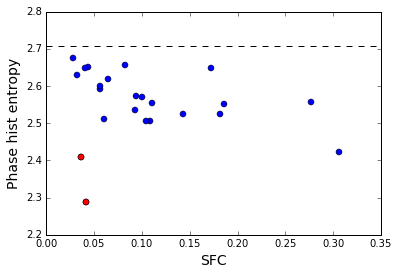

In [324]:
%matplotlib inline
sys.path.append('/Volumes/kaylab/Code.Repository/Python/') # where OpenEphys is stored
ddir = '/Volumes/kaylab/DataStores/Data/BO/SiProbe/' # data directory
# Plot entropy of phase histograms vs SFC
ENT = []
for i in range(len(SPHprod)):
    if SPHprod[i].size < 30:
        ENT.append(np.nan)
    else:
        [yo,bleh]=np.histogram(SPHprod[i],nbins)
        ENT.append(stats.entropy(yo))

plt.plot(SFCb_max,ENT,'o')
plt.plot([0,0.35],[stats.entropy(np.ones(nbins)),stats.entropy(np.ones(nbins))],'k--')
# plot undersampled spikes!
plt.plot([SFCb_max[9],SFCb_max[13]],[ENT[9],ENT[13]],'ro')
plt.xlabel('SFC',fontsize=14),plt.ylabel('Phase hist entropy',fontsize=14)
plt.savefig('figs/'+dfold+'_ENTvsSFC2reddots.png', bbox_inches='tight')

In [322]:
os.chdir('/Volumes/kaylab/Personal.Folders/BO/Python/SiProbe/RK90/2017')

In [ ]:
test=el.spike_train_generation.homogeneous_poisson_process(rate=10.0*Hz, t_start=0.0*s, t_stop=100.0*s)

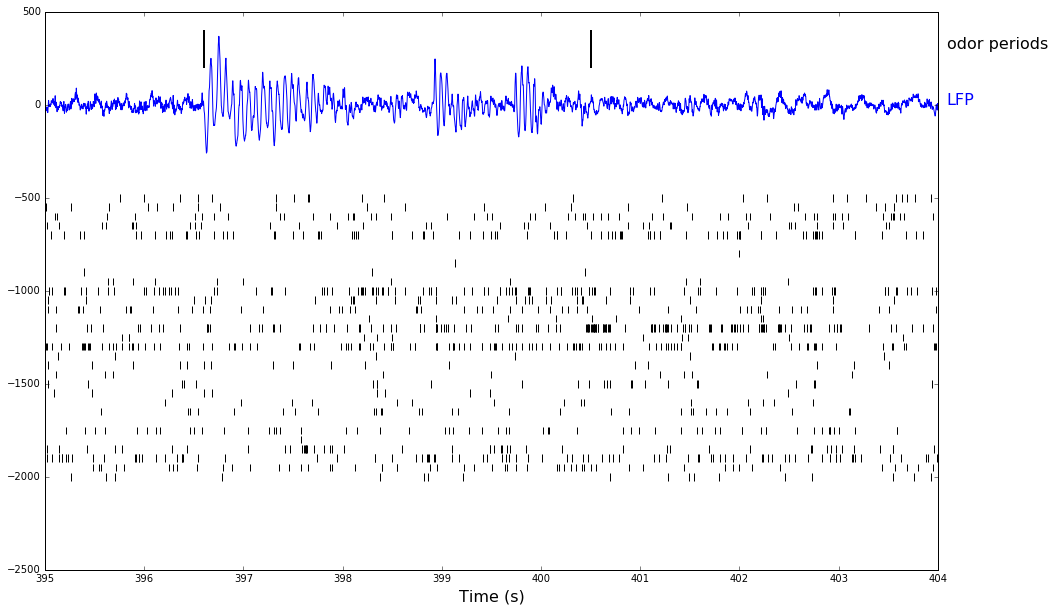

In [28]:
# Plot odor periods, LFP, and spikes for entire session
includeHP = 0
sflag = 0
sstime = np.linspace(0,ssLFP.size/sssf,ssLFP.size) # subsampled time

x1 = 395
x2 = 404
plt.figure(figsize=(16,10))
plt.eventplot(odor_periods/sf, orientation='horizontal', lineoffsets=300, linelengths=200, 
              linewidths=2, colors='k', linestyles='solid', hold=None, data=None)
plt.text(x2+0.01*(x2-x1),300,'odor periods',fontsize=16)
plt.plot(sstime,0.1*ssLFP,color = 'b')
plt.text(x2+0.01*(x2-x1),0,'LFP',color = 'b',fontsize=16)
if includeHP == 1:
    plt.plot(np.linspace(0,CONT1.size/sf,CONT1.size),0.3*CONT1-250,color = 'k')
    plt.text(x2+0.01*(x2-x1),-250,'sh1 - highpass',color = 'k')
    plt.plot(np.linspace(0,CONT2.size/sf,CONT2.size),0.3*CONT2-350,color = 'k')
    plt.text(x2+0.01*(x2-x1),-350,'sh2 - highpass',color = 'k')
for i in range(len(SPK)-1):
    plt.eventplot(SPK[i]/sf, orientation='horizontal', lineoffsets=-500-i*50, linelengths=40, 
              linewidths=1, colors='k', linestyles='solid', hold=None, data=None,label = 'TTL')
    #plt.text(x2+0.01*(x2-x1),-500-i*50,clust_names[i]) #label spike trains
plt.xlim([x1,x2]),plt.xlabel('Time (s)',fontsize=16)
if sflag == 1:
    plt.savefig('figs/'+dfold+'_OP-LFP-SPK_150s.png', bbox_inches='tight')
    #plt.savefig('figs/'+dfold+'_beta-epochs1.png', bbox_inches='tight')
    # plt.savefig('figs/'+dfold+'_PeriodicBurst2_zoom.png', bbox_inches='tight')
    # plt.savefig('figs/'+dfold+'_GammaLeak?.png', bbox_inches='tight')


In [ ]:
dfile1 = ddir + dfold + '/2017/shank1CMR/' + dfold + '_shank1CMR' + '.kwik'
import h5py
with h5py.File(dfile1,'r') as D:
    #for viewing contents of folders
    dv=D['/channel_groups/0/spikes']
    for i in iter(dv):
        print(i)

In [ ]:
dfile1 = ddir + dfold + '/2017/shank1CMR/' + dfold + '_shank1CMR' + '.kwik'
import h5py
with h5py.File(dfile1,'r') as D:
    dv=D.get('/channel_groups/')
    #dv=D.get('/channel_groups/0/spikes/clusters/main')
    npdv=np.array(dv)
    for i in iter(dv):
        print(i)

In [ ]:
thlg = 0.2*max(LFPlg_env) # low gamma threshold
thhg = 0.2*max(LFPhg_env) # high gamma threshold
yolg = LFPlg_env >= thlg
yohg = LFPhg_env >= thhg
yolg = yolg.astype(float) # convert boolean to float
yohg = yohg.astype(float) # convert boolean to float
yolg = np.diff(yolg)
yohg = np.diff(yohg)

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(np.linspace(0,1,5000),yolg[0:5000])
plt.plot(np.linspace(0,1,5000),ssLFP[0:5000]/400)
plt.plot(np.linspace(0,1,5000),LFPlg_env[0:5000]/400)

In [ ]:
bins = np.arange(0,len(LFPb_ph_op[i]),bw)
[binned_spikes,bleh] = np.histogram(SPK_op[i][s][0][sind],bins)
if len(binned_spikes) < len(LFPb_ph_op[i]): # ensure binned spikes and LFP are same len
    binned_spikes=np.append(binned_spikes,0) # add zero to end
elif len(binned_spikes) > len(LFPb_ph_op[i]):
    binned_spikes=np.delete(binned_spikes,0) # delete 1st element
f, Cxy = signal.coherence(binned_spikes, ssLFP_segment, sssf, nperseg=1024)

In [ ]:
binned_spikes=np.append(binned_spikes,0)

In [ ]:
# obtain start and stop of low and high gamma periods above a threshold
thlg = 0.25*max(LFPlg_env) # low gamma threshold
thhg = 0.2*max(LFPhg_env) # high gamma threshold
yolg = LFPlg_env >= thlg
yohg = LFPhg_env >= thhg
yolg = yolg.astype(float) # convert boolean to float
yohg = yohg.astype(float) # convert boolean to float
yolg = np.diff(yolg)
yohg = np.diff(yohg)
startlg = np.squeeze(np.array(np.where(yolg == 1)))
stoplg = np.squeeze(np.array(np.where(yolg == -1)))
stoplg = stoplg[stoplg != 0] # if LFP happends start with high power then first stop will be 0
if len(stoplg) == len(startlg)+1:
    stoplg = np.delete(stoplg,0) # start and stop must be same length and aligned!
starthg = np.squeeze(np.array(np.where(yohg == 1)))
stophg = np.squeeze(np.array(np.where(yohg == -1)))
stophg = stophg[stophg != 0] # if LFP happends start with high power, then first stop will be 0
if len(stophg) == len(starthg)+1:
    stophg = np.delete(stophg,0) # start and stop must be same length and aligned!

# Get spike-LFP phase products low/high gamma periods
SPHprodlg = list() # SPHprodlg will have length = len(SPK)
SPHprodhg = list()
RPHprodlg = list() # SPHprodlg will have length = len(SPK)
RPHprodhg = list()
lg_tot_spk = np.zeros(len(SPK)) # also save tot number of spikes in lg/hg
hg_tot_spk = np.zeros(len(SPK))
LFPlg_cat = [] # initialize list which I will later convert to 1D array (np.append is suuuuper slow)
SPKlg_cat = [None]*len(SPK)
LFPhg_cat = np.empty(0) # initialize array which will concatenate all beta periods
SPKhg_cat = [None]*len(SPK)
for i in range(len(SPK)):
    # low gamma
    SPHprodlg_temp = list()
    RPHprodlg_temp = list()
    SPKlg_cat[i] = np.empty(0) # np.append is slow, but since there are few spikes per j it ok
    cumulative_time_shiftlg = 0 # cumulative shift in time to concatenate spike times
    print(str(i))
    for j in range(startlg.size):
        ind_temp = np.array(np.where((SPK[i] > 10*startlg[j]) & (SPK[i] < 10*stoplg[j]-10)))
        spk_temp = SPK[i][ind_temp] - 10*startlg[j]
        if s == 0
            LFPlg_cat.append(LFPlg[startlg[j]:stoplg[j]]) # only cat LFP once
        [SFprod,RFprod] = spike_field_prod_with_rand(spk_temp,LFPlg_ph[startlg[j]:stoplg[j]])
        SPHprodlg_temp.append(SFprod)
        RPHprodlg_temp.append(RFprod)
        lg_tot_spk[i] = lg_tot_spk[i] + ind_temp.size
        SPKlg_cat[i] = np.append(SPKlg_cat[i],spk_temp+cumulative_time_shiftlg)
        cumulative_time_shiftlg = cumulative_time_shiftlg + stoplg[j]-startlg[j]
    # save spike-phase products for each cluster
    if len(SPHprodlg_temp) == 0:
        # np.hstack is unable to deal with empty entries (stupid)
        SPHprodlg.append(np.empty( shape=(0, 0) ))
        RPHprodlg.append(np.empty( shape=(0, 0) ))
        # must add empty ARRAY (not LIST) for later processing
    else:
        SPHprodlg.append(np.hstack(SPHprodlg_temp))
        RPHprodlg.append(np.hstack(RPHprodlg_temp))



In [ ]:

bool_array =(SPK_op[17][0] > startb_op[17][1]) & (SPK_op[17][0] < stopb_op[17][1])
sind = np.array(np.where(np.squeeze(bool_array)))
sind

In [ ]:
bins = np.arange(0,10*len(LFPb_ph_op[17]),bw)
[binned_spikes,bleh] = np.histogram(SPK_op[17][0][0][sind],bins)

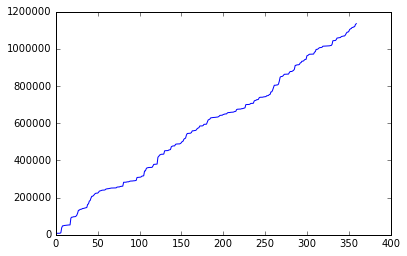

In [226]:
plt.plot(SPKb_cat[14])

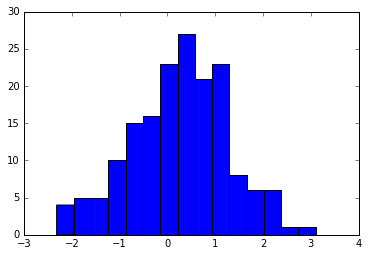

In [262]:
yo=plt.hist(SPHprod[12].T,15)

In [261]:
mo = yo[0]/np.sum(yo[0])
stats.entropy(yo[0])

2.0386969652224747

In [256]:
[yo,bleh]=np.histogram(RPHprod[12],15)
yo
stats.entropy(yo)

2.6680580836453851

In [253]:
nbins

10

In [193]:
i=13
yo = LFPb_env_op[i] >= thb
yo = yo.astype(float) # convert boolean to float
yo = np.diff(yo)
startb_test = 10*np.squeeze(np.array(np.where(yo == 1))) # multiply by 10 becaise LFP is subsampled
stopb_test = 10*np.squeeze(np.array(np.where(yo == -1))) # multiply by 10 becaise LFP is subsampled

In [197]:
i=13
yo = LFPb_env_op[i] >= thb
yo = yo.astype(float) # convert boolean to float
yo = np.diff(yo)

7

In [263]:
odor_periods

array([  2475000.,   2547000.,   2898000.,   2961000.,   3402000.,
         3510000.,   3960000.,   4005000.,   4455000.,   4536000.,
         4950000.,   5040000.,   5580000.,   5670000.,   6084000.,
         6147000.,   6462000.,   6579000.,   6930000.,   7020000.,
         7983000.,   8046000.,   8352000.,   8442000.,   8829000.,
         8883000.,   9189000.,   9252000.,   9567000.,   9648000.,
         9999000.,  10098000.,  10512000.,  10575000.,  11016000.,
        11088000.,  11475000.,  11547000.,  11898000.,  12015000.,
        12789000.,  12861000.,  13149000.,  13212000.,  13554000.,
        13653000.,  13824000.,  13869000.,  14418000.,  14499000.,
        14895000.,  14976000.,  15444000.,  15570000.,  15858000.,
        15930000.,  16254000.,  16344000.,  16641000.,  16731000.])

In [243]:
SFCb_max[8]

0.04206806273428431